In order to do this, we first
compute an image embedding using a self-supervised ViT-H/16 network pretrained on ImageNet-22k, and
use cosine-similarity as a distance measure between images. Then, we perform k-means clustering of the
uncurated data.


In [1]:
import open_clip
import torchvision
from matplotlib import pyplot as plt
import torchvision.transforms.functional as TF

import torch
import torch.nn as nn
import kornia
from kornia import augmentation as K


from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import cv2

/home/ettore/.conda/envs/dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
kornia_preprocess = nn.Sequential(
    K.SmallestMaxSize(
        224,
        resample=kornia.constants.Resample.BICUBIC,
    ),
    K.CenterCrop(
        size=(224, 224),
        resample=kornia.constants.Resample.BICUBIC,
    ),
    kornia.enhance.Normalize(
        mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]),
        std=torch.tensor([0.26862954, 0.26130258, 0.27577711]),
    ),
)

model, _, _ = open_clip.create_model_and_transforms(
    "ViT-B-16", pretrained="openai", force_quick_gelu=True
)
model.eval()
model.visual.output_tokens = True

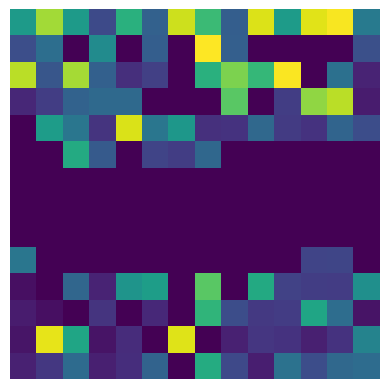

In [3]:
from sklearn.preprocessing import minmax_scale

image = torchvision.io.read_image(
    # "datasets/imagenet-a/n01641577/0.038738_agama _ newt_0.7465035.jpg"
    # "datasets/imagenet-a/n02837789/0.003724_apron _ apron_0.6133991.jpg"
    # "datasets/imagenet-a/n03584829/0.005642_soap dispenser _ digital clock_0.25785252.jpg"
    # "datasets/imagenet-a/n01694178/0.003951_newt _ newt_0.99884206.jpg"
    "airplane.jpg"
)

image = image.float().div(255)
image = kornia_preprocess(image)
model.visual.output_tokens = True

with torch.no_grad():
    encoded_image, embeddings = model.visual(image)


fg_pca = PCA(n_components=1)
fg_pca_images = fg_pca.fit_transform(embeddings.cpu().squeeze(0).numpy())
fg_pca_images = minmax_scale(fg_pca_images)

mask = (fg_pca_images < 0.4).ravel()
# mask = (fg_pca_images > 0.6).ravel()

fg_pca_images[np.logical_not(mask)] = 0
fg_pca_images = fg_pca_images.reshape([14, 14])

plt.imshow(fg_pca_images)
plt.axis("off")
plt.show()

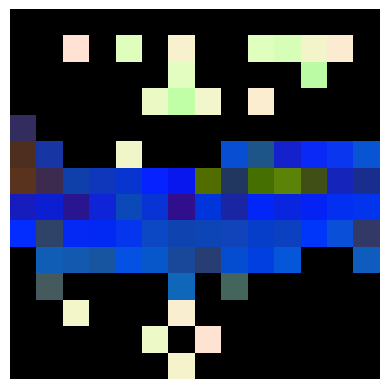

In [4]:
# apply the mask to the embeddings
masked_embeddings = embeddings.squeeze(0).clone()
masked_embeddings[mask] = 0
masked_embeddings.shape

pca = PCA(n_components=3)
patches = masked_embeddings
pca_features = pca.fit_transform(patches)
fg_result = minmax_scale(pca_features)

fg_result[np.logical_not(~mask)] = 0
fg_result = fg_result.reshape([14, 14, 3])

plt.imshow(fg_result)
plt.axis("off")
plt.show()

In [5]:
with torch.no_grad():
    encoded_image, embeddings = model.visual(image)  # ensure batch dim

# Remove CLS token
patch_embeddings = embeddings[:, :, :].squeeze(0)  # (196, dim)

In [6]:
patch_embeddings.shape

torch.Size([196, 768])

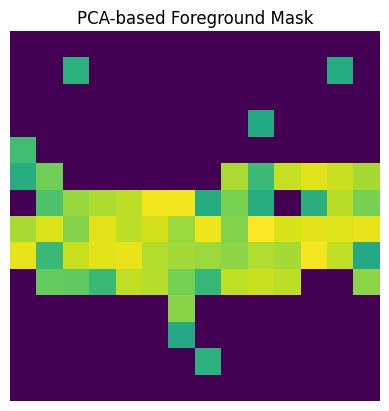

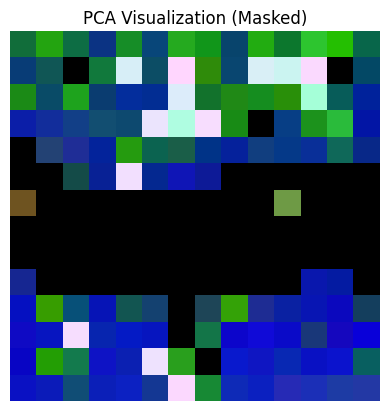

In [38]:
# PCA for masking
fg_pca = PCA(n_components=1)
fg_pca_scores = fg_pca.fit_transform(patch_embeddings.cpu().numpy())
fg_pca_scores = minmax_scale(fg_pca_scores)

# mask = fg_pca_scores.ravel() < 0.4  # define background
mask = fg_pca_scores.ravel() > 0.6  # define foreground

# Visualize the mask
mask_image = fg_pca_scores.copy()
mask_image[~mask] = 0
mask_image = mask_image.reshape(14, 14)

plt.imshow(mask_image)
plt.axis("off")
plt.title("PCA-based Foreground Mask")
plt.show()

# Zero out background embeddings
masked_embeddings = patch_embeddings.clone()
masked_embeddings[mask] = 0

# PCA to visualize
pca = PCA(n_components=3)
pca_result = pca.fit_transform(masked_embeddings.cpu().numpy())
pca_result = minmax_scale(pca_result)

# Zero out background for visualization
pca_result[mask] = 0
pca_result = pca_result.reshape(14, 14, 3)

plt.imshow(pca_result)
plt.axis("off")
plt.title("PCA Visualization (Masked)")
plt.show()

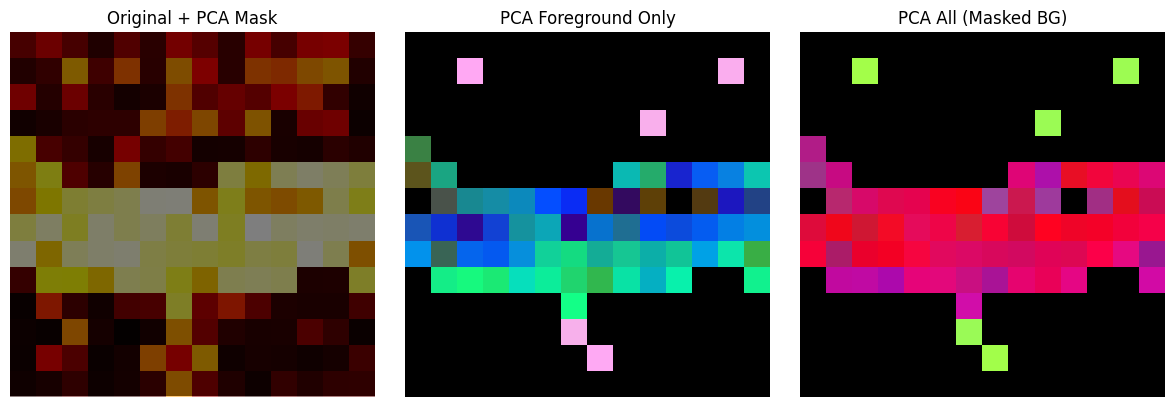

In [3]:
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF
import kornia
from kornia import augmentation as K
import open_clip

# === Configuration ===
IMAGE_PATH = "airplane.jpg"
IMAGE_SIZE = 224  # must be divisible by 14
PATCH_RES = 14  # ViT-B/16 => 14x14 patches at 224x224 input
SAVE_PATH = "outputs/combined_plot.jpg"
os.makedirs("outputs", exist_ok=True)

# === Kornia Preprocessing ===
kornia_preprocess = nn.Sequential(
    K.SmallestMaxSize(IMAGE_SIZE, resample=kornia.constants.Resample.BICUBIC),
    K.CenterCrop(
        size=(IMAGE_SIZE, IMAGE_SIZE), resample=kornia.constants.Resample.BICUBIC
    ),
    kornia.enhance.Normalize(
        mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]),
        std=torch.tensor([0.26862954, 0.26130258, 0.27577711]),
    ),
)

# === Load Model ===
model, _, _ = open_clip.create_model_and_transforms(
    "ViT-B-16", pretrained="openai", force_quick_gelu=True
)
model.eval()
model.visual.output_tokens = True

# === Load Image ===
image = torchvision.io.read_image(IMAGE_PATH).float().div(255)  # (C, H, W)
image_vis = TF.resize(image, IMAGE_SIZE).permute(1, 2, 0).numpy()  # For plotting
image_input = kornia_preprocess(image)  # Add batch dim

# === Get Patch Embeddings ===
with torch.no_grad():
    _, embeddings = model.visual(image_input)
patch_embeddings = embeddings[:, :, :].squeeze(0).cpu().numpy()  # (196, D)

# === Foreground PCA Mask ===
fg_pca = PCA(n_components=1)
fg_scores = minmax_scale(fg_pca.fit_transform(patch_embeddings)).reshape(
    PATCH_RES, PATCH_RES
)
mask = fg_scores > 0.6

# === PCA of Foreground Only ===
masked_patches = patch_embeddings[mask.ravel()]
pca_fg = PCA(n_components=3)
fg_rgb = minmax_scale(pca_fg.fit_transform(masked_patches))

# Fill only masked areas in full grid
fg_result = np.zeros((PATCH_RES * PATCH_RES, 3), dtype=np.float32)
fg_result[mask.ravel()] = fg_rgb
fg_result = fg_result.reshape(PATCH_RES, PATCH_RES, 3)

# === PCA of All Patches (mask background) ===
pca_all = PCA(n_components=3)
all_rgb = minmax_scale(pca_all.fit_transform(patch_embeddings)).reshape(
    PATCH_RES, PATCH_RES, 3
)
all_rgb[~mask] = 0  # mask background

# === Plot All Three ===
plt.figure(figsize=(12, 4))

# 1. Original with Mask Overlay
plt.subplot(1, 3, 1)
plt.imshow(image_vis.astype(np.uint8))
plt.imshow(fg_scores, extent=(0, IMAGE_SIZE, IMAGE_SIZE, 0), cmap="hot", alpha=0.5)
plt.title("Original + PCA Mask")
plt.axis("off")

# 2. PCA Foreground
plt.subplot(1, 3, 2)
plt.imshow(fg_result)
plt.title("PCA Foreground Only")
plt.axis("off")

# 3. PCA All Patches (masked)
plt.subplot(1, 3, 3)
plt.imshow(all_rgb)
plt.title("PCA All (Masked BG)")
plt.axis("off")

plt.tight_layout()
plt.show()
# plt.savefig(SAVE_PATH)
# plt.close()

# print(f"✅ Combined plot saved to: {SAVE_PATH}")